In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_rows=350
pd.options.display.max_columns=350

#Models for parameter selection
from sklearn.model_selection import GridSearchCV

#Split data
from sklearn.model_selection import train_test_split

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#module with geometric and harmonic means
from scipy import stats

In [2]:
#Helper Functions

#Score predictions of fitted model.
def score_results(model, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('R^2:', round(r2_score(y, prediction), 4))
    mae = round(mean_absolute_error(y, prediction),2)
    print('MAE:', mae)
    
def plot_boxplot_w_data(colname, df, figsize=(15,3), title='Boxplot', xmin=0, xmax=1_000, boxplot_on=True):
    '''Returns boxplot with orange data points overlaid.'''
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set(xlim = (xmin, xmax))
    if boxplot_on == True:
        ax=sns.boxplot(x=colname, data=df, linewidth=4, fliersize=6)
    ax=sns.stripplot(x=colname, data=df, color="orange", jitter=0.35, size=4)  #Credit: https://python-graph-gallery.com/39-hidden-data-under-boxplot/
    ax.set_title(f'{title}')    
    plt.show()    

In [3]:
iowa_houses=pd.read_csv('data/iowa_train.csv')
data = iowa_houses.copy()

In [4]:
#Code ordinal features as numbers.
ord_coding={
        'ExterQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'ExterCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'HeatingQC' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'KitchenQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'Functional' : {'Typ':7, 'Min2':6, 'Min1':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
       }

data.replace(ord_coding, inplace=True)

In [5]:
#Subset the features.
#Overall condition scale 1-10; Functional scale 1-7
data = data[['OverallQual','KitchenQual','BsmtQual','HeatingQC','SalePrice']]

In [6]:
#Drop rows with any nulls for simplicity
data.dropna(axis='index', inplace=True)
print(data.shape)

#Convert object columns to float.  Need float for mean calcs.
conversion_cols = data.select_dtypes('object').columns

data[conversion_cols] = data[conversion_cols].astype('float')

(1423, 5)


In [7]:
#Get feature correlations to SalePrice in train.
print('Feature correlations to SalePrice:\n')
data.corr()['SalePrice'].sort_values(ascending=False).round(4)

Feature correlations to SalePrice:



SalePrice      1.0000
OverallQual    0.7879
KitchenQual    0.6551
BsmtQual       0.6440
HeatingQC      0.4189
Name: SalePrice, dtype: float64

In [8]:
#Split out X and y.  Split out train and test.
X = data
y = data.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)

In [9]:
#Observe rating median < hmean < gmean < amean.
X_train.describe()

,OverallQual,KitchenQual,BsmtQual,HeatingQC
count,1138.00000,1138.000000,1138.000000,1138.000000
mean,6.13884,3.525483,3.575571,4.163445
std,1.39040,0.656314,0.677572,0.953445
min,1.00000,2.000000,2.000000,1.000000
25%,5.00000,3.000000,3.000000,3.000000
50%,6.00000,3.000000,4.000000,5.000000
75%,7.00000,4.000000,4.000000,5.000000
max,10.00000,5.000000,5.000000,5.000000


In [10]:
y_train.describe()

count      1138.000000
mean     183128.873462
std       81241.428965
min       34900.000000
25%      130625.000000
50%      164945.000000
75%      216752.750000
max      755000.000000
Name: SalePrice, dtype: float64

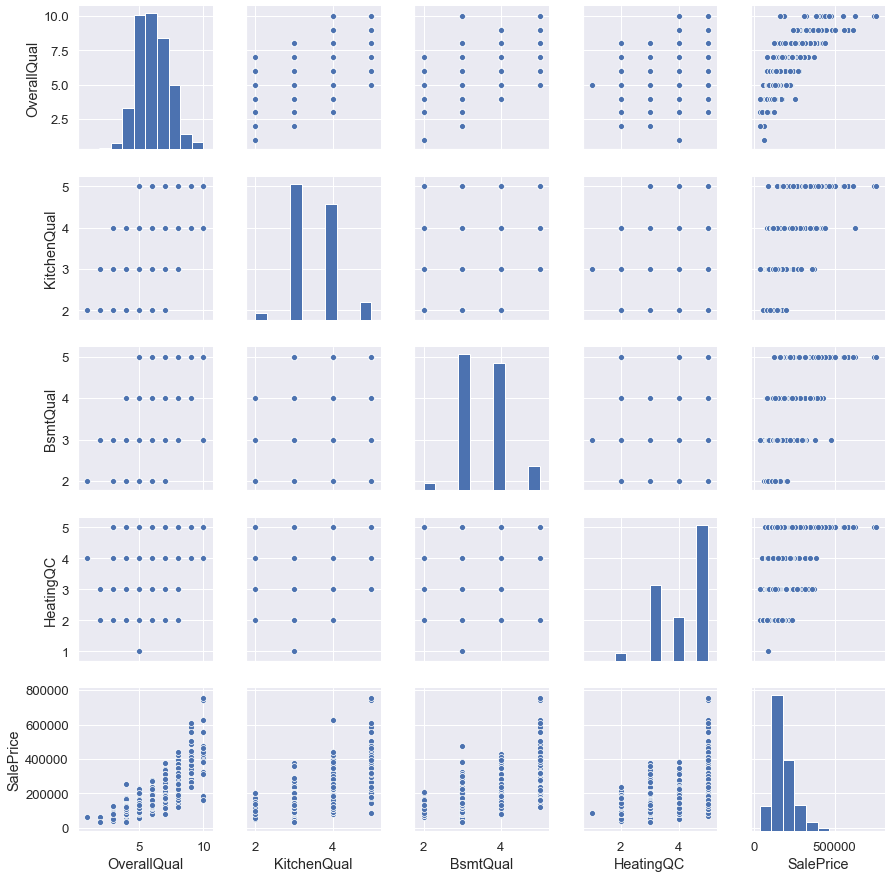

In [11]:
#Pair plot train including SalePrice.
sns.set(font_scale=1.2)
sns.pairplot(pd.concat([X_train, y_train],axis='columns'))
plt.show()

In [12]:
X_train.head(1)

,OverallQual,KitchenQual,BsmtQual,HeatingQC
515,10,5.0,5.0,5.0


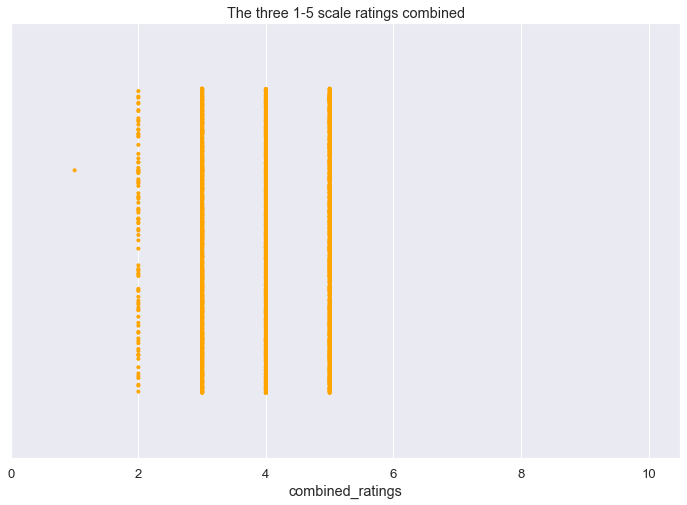

In [13]:
#Visualize observations for KitchenQual, BsmtQual, and HeatingQC combined.  All are scale 1-5.
comb1_5_ratings= pd.concat([X_train['KitchenQual'], X_train['BsmtQual'], X_train['HeatingQC']], ignore_index=True)
comb1_5_ratings = pd.DataFrame(comb1_5_ratings, columns=['combined_ratings'])

plot_boxplot_w_data('combined_ratings', comb1_5_ratings, figsize=(12, 8), title='The three 1-5 scale ratings combined',\
                    xmin=0, xmax=10.5, boxplot_on=False)

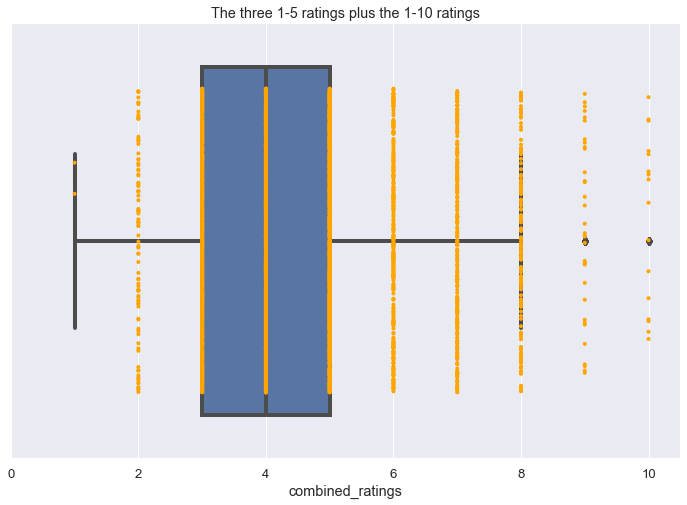

In [14]:
#Visualize observations for OverallQual, KitchenQual, BsmtQual, and HeatingQC combined.  
# All are scale 1-5 except for OverallQual.  OverallQual is 1-10.
comb_ratings= pd.concat([X_train['OverallQual'], X_train['KitchenQual'], X_train['BsmtQual'], X_train['HeatingQC']],\
                        ignore_index=True)
comb_ratings = pd.DataFrame(comb_ratings, columns=['combined_ratings'])

plot_boxplot_w_data('combined_ratings', comb_ratings, figsize=(12, 8), title='The three 1-5 ratings plus the 1-10 ratings',\
                    xmin=0, xmax=10.5, boxplot_on=True)

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
#Get four means in train and test.
rating_cols = ['OverallQual','KitchenQual','BsmtQual','HeatingQC']

X_train.loc[:, 'rat_median'] = X_train.loc[:, rating_cols].median(axis=1)
X_train.loc[:, 'rat_hmean'] = stats.hmean(X_train.loc[:, rating_cols], axis=1)
X_train.loc[:, 'rat_gmean'] = stats.gmean(X_train.loc[:, rating_cols], axis=1)
X_train.loc[:, 'rat_amean'] = X_train.loc[:, rating_cols].mean(axis=1)

X_test.loc[:, 'rat_median'] = X_test.loc[:, rating_cols].median(axis=1)
X_test.loc[:, 'rat_hmean'] = stats.hmean(X_test.loc[:, rating_cols], axis=1)
X_test.loc[:, 'rat_gmean'] = stats.gmean(X_test.loc[:, rating_cols], axis=1)
X_test.loc[:, 'rat_amean'] = X_test.loc[:, rating_cols].mean(axis=1)

In [17]:
X_train.head(2)

,OverallQual,KitchenQual,BsmtQual,HeatingQC,rat_median,rat_hmean,rat_gmean,rat_amean
515,10,5.0,5.0,5.0,5.0,5.714286,5.946036,6.25
672,6,3.0,4.0,3.0,3.5,3.692308,3.833659,4.00


In [18]:
X_test.head(1)

,OverallQual,KitchenQual,BsmtQual,HeatingQC,rat_median,rat_hmean,rat_gmean,rat_amean
1250,7,5.0,3.0,5.0,5.0,4.565217,4.78674,5.0


In [19]:
comb_ratings.head()

,combined_ratings
0,10.0
1,6.0
2,5.0
3,6.0
4,7.0


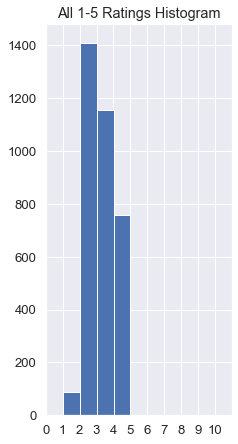

In [20]:
#Combined 1-5 ratings histogram.
fig, ax = plt.subplots(1,1,figsize=(3.33,7.2))
ax.set(title='All 1-5 Ratings Histogram', xlim = (0,11), xticks = [0,1,2,3,4,5,6,7,8,9,10])
bins0 = [0, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01, 10.01]
ax.hist(comb1_5_ratings['combined_ratings'], bins=bins0)
plt.show()

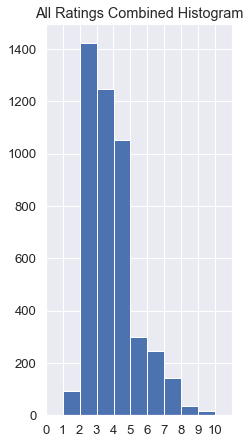

In [21]:
#Combined ratings histogram.
fig, ax = plt.subplots(1,1,figsize=(3.33,7.2))
ax.set(title='All Ratings Combined Histogram', xlim = (0,11), xticks = [0,1,2,3,4,5,6,7,8,9,10])
bins0 = [0, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01, 10.01]
ax.hist(comb_ratings['combined_ratings'], bins=bins0)
plt.show()

Rating Histograms:


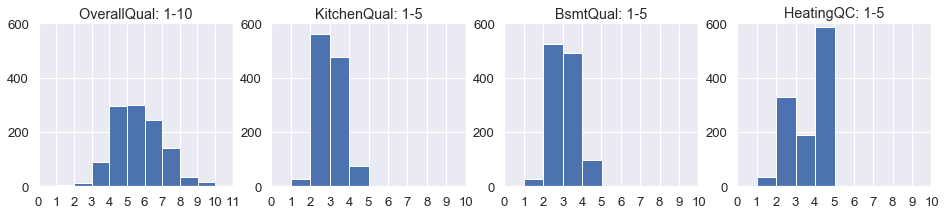


Mean Histograms -- Mean of Four: OverallQual, KitchenQual, BsmtQual, and HeatingQC



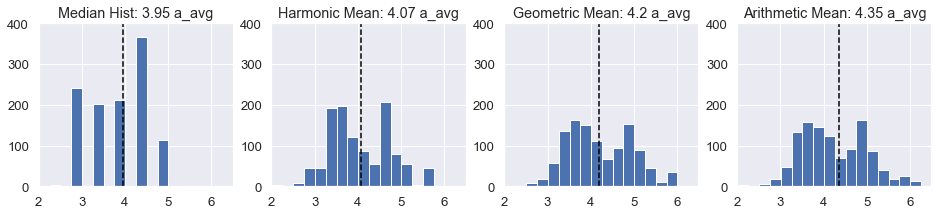

Arithmetic averages (a_avg) low to high: median <= hmean <= gmean <= amean


In [22]:
#Rating column histograms.
print('Rating Histograms:')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,3))

ax1.set(title='OverallQual: 1-10', xlim=(0,11), ylim=(0,600), xticks = [0,1,2,3,4,5,6,7,8,9,10,11], yticks = [0,200,400,600])
ax2.set(title='KitchenQual: 1-5',xlim=(0,10), ylim=(0,600), xticks = [0,1,2,3,4,5,6,7,8,9,10], yticks = [0,200,400,600])
ax3.set(title='BsmtQual: 1-5',xlim=(0,10), ylim=(0,600), xticks = [0,1,2,3,4,5,6,7,8,9,10], yticks = [0,200,400,600])
ax4.set(title='HeatingQC: 1-5',xlim=(0,10), ylim=(0,600), xticks = [0,1,2,3,4,5,6,7,8,9,10], yticks = [0,200,400,600])

bins1 = [ 0, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01, 10.01]
ax1.hist(X_train['OverallQual'], bins=bins1)
ax2.hist(X_train['KitchenQual'],  bins=bins1)
ax3.hist(X_train['BsmtQual'], bins=bins1)
ax4.hist(X_train['HeatingQC'],bins=bins1)
plt.show()

#Mean histograms.
print('\nMean Histograms -- Mean of Four: OverallQual, KitchenQual, BsmtQual, and HeatingQC\n')

avg_median=round(X_train['rat_median'].mean(),2)
avg_hmean=round(X_train['rat_hmean'].mean(),2)
avg_gmean=round(X_train['rat_gmean'].mean(),2)
avg_amean=round(X_train['rat_amean'].mean(),2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,3))
ax1.set(title=f'Median Hist: {avg_median} a_avg', xlim = (2,6.5), ylim = (0,400), xticks = [2,3,4,5,6,7])
ax2.set(title=f'Harmonic Mean: {avg_hmean} a_avg', xlim = (2,6.5), ylim = (0,400), xticks = [2,3,4,5,6,7])
ax3.set(title=f'Geometric Mean: {avg_gmean} a_avg', xlim = (2,6.5), ylim = (0,400), xticks = [2,3,4,5,6,7])
ax4.set(title=f'Arithmetic Mean: {avg_amean} a_avg', xlim = (2,6.5), ylim = (0,400), xticks = [2,3,4,5,6,7])

ax1.axvline(x=avg_median, color = 'black', ls='--', alpha=1)
ax2.axvline(x=avg_hmean, color = 'black', ls='--', alpha=1)
ax3.axvline(x=avg_gmean, color = 'black', ls='--', alpha=1)
ax4.axvline(x=avg_amean, color = 'black', ls='--', alpha=1)

bins2 = np.arange(0.01,10.25,0.25)  #41 bins between 0.01 and 10.01.
a,b, c = ax1.hist(X_train['rat_median'], bins=bins2)
ax2.hist(X_train['rat_hmean'], bins=bins2)
ax3.hist(X_train['rat_gmean'], bins=bins2)
a,b,c = ax4.hist(X_train['rat_amean'], bins=bins2)
plt.show()

print('Arithmetic averages (a_avg) low to high: median <= hmean <= gmean <= amean')

In [23]:
#Regression with rating columns.
rating_cols = ['OverallQual','KitchenQual','BsmtQual','HeatingQC']
           
lr=LinearRegression(fit_intercept=True)

lr.fit(X_train[rating_cols], y_train)
y_preds = lr.predict(X_test[rating_cols])    
score_results(lr, y_test, y_preds)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.6929
MAE: 29152.54


In [29]:
#Regression with rating columns averaged by: 
#(1) median 
#(2) harmonic mean
#(3) geometric mean
#(4) arithmetic mean

#Performance worsens according to:  median < hmean < gmean < amean.

mean_col = ['rat_amean', 'rat_gmean', 'rat_hmean','rat_median']
lr=LinearRegression(fit_intercept=True)

for c in mean_col: 
    lr.fit(X_train[c].values.reshape(-1,1), y_train)
    y_predsAvg = lr.predict(X_test[c].values.reshape(-1,1))    
    score_results(lr, y_test, y_predsAvg)
    print('Average column:', c,'\n')

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.6345
MAE: 32350.11
Average column: rat_amean 

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.6044
MAE: 33762.05
Average column: rat_gmean 

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.5771
MAE: 34956.29
Average column: rat_hmean 

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.3915
MAE: 42603.38
Average column: rat_median 



#### https://stats.stackexchange.com/questions/23117/which-mean-to-use-and-when

#### https://medium.com/@JLMC/understanding-three-simple-statistics-for-data-visualizations-2619dbb3677a

##### harmonic <= geometric <= arithmetic
##### The  exception is for uniform data, in which case they’re the same.

In [25]:
comb_ratings.mean()

combined_ratings    4.350835
dtype: float64

In [26]:
comb_ratings.std() * 3

combined_ratings    4.307109
dtype: float64

In [27]:
comb_ratings.mean() + (comb_ratings.std() * 3)

combined_ratings    8.657944
dtype: float64